# Testes e Treinamento

## Prequential Evaluation

Limpeza: Removendo espaços, identificadores (Flow ID, Timestamp, Umma,ed: 0) e colunas vazias...
Pré-processamento: Convertendo infinitos e preenchendo valores nulos...
Target: Processando coluna 'Label' como Binário (0=Normal, 1=Attack)...
Seleção de Features: Iniciando pipeline de redução de dimensionalidade...

--- Iniciando Processo de Seleção de Features (Total: 83) ---
Variância: 16 features removidas. Restantes: 67
Correlação (>0.95): 33 features redundantes removidas. Restantes: 34
Random Forest: Pular.
Features Finais (34) - ['Source Port_Entropy', 'Destination Port_Entropy', 'Flow Duration', 'Total Fwd Packets', 'Total Backward Packets', 'Total Length of Fwd Packets', 'Total Length of Bwd Packets', 'Fwd Packet Length Std', 'Bwd Packet Length Max', 'Bwd Packet Length Min', 'Bwd Packet Length Mean', 'Flow Bytes/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Min', 'Fwd IAT Mean', 'Bwd IAT Mean', 'Bwd IAT Min', 'Fwd PSH Flags', 'Fwd Header Length', 'Bwd Header Length', 'Bwd Packe

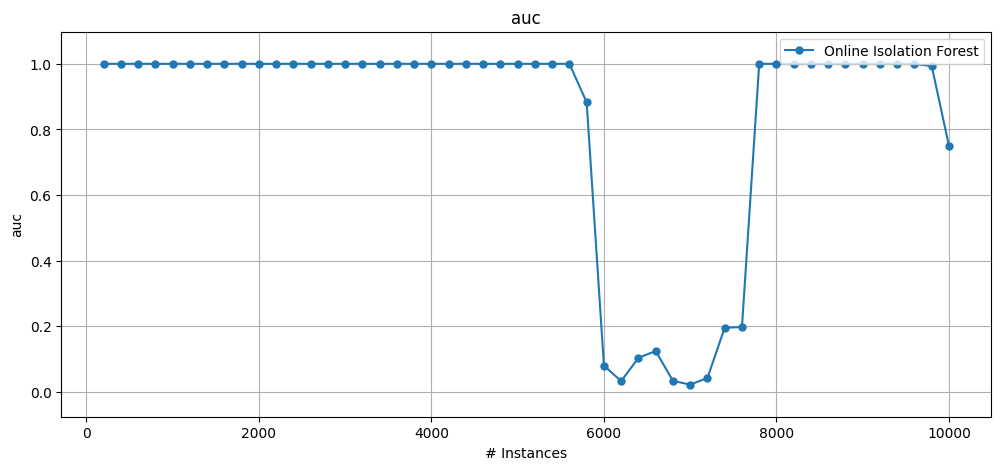

In [ ]:
from capymoa.anomaly import OnlineIsolationForest
from capymoa.evaluation.visualization import plot_windowed_results
from capymoa.evaluation import prequential_evaluation_anomaly
from py.DataStreamProcessor import newStream
import pandas as pd

INICIO = 0
FIM = 10000
TOTAL_AMOSTRAS = FIM - INICIO
MAX_INSTANCES = TOTAL_AMOSTRAS

df = pd.read_csv(
    'datasets/CICDDoS2019/data/Exp_janela/SNMP_DNS_1s_0112.csv', 
    skiprows=range(1, INICIO), 
    nrows=TOTAL_AMOSTRAS
)

stream, targets, features = newStream(
    df=df, 
    target_label_col='Label', 
    binary_label=True, 
    normalize_method="MinMaxScaler", 
    threshold_var=0.75,
    threshold_corr=0.95,
    top_n_features=None,
    stream=True
)

oif = OnlineIsolationForest(schema=stream.get_schema())

results_oif = prequential_evaluation_anomaly(
    stream=stream, learner=oif, window_size=200
)

print(f"AUC: {results_oif.auc()}")
# display(results_oif.windowed.metrics_per_window())
plot_windowed_results(results_oif, metric="auc", save_only=False)

# Execução e Resultados

## Stream

In [ ]:
from py.DataStreamProcessor import DataStreamProcessor
import pandas as pd

inicio = 5000
fim = 8000
quantidade = fim - inicio
MAX_INSTANCES = quantidade

# df = pd.read_csv(
#     'datasets/CICDDoS2019/data/Exp_janela/SNMP_DNS_1s_0112.csv', 
#     skiprows=range(1, inicio), 
#     nrows=quantidade
# )

processor = DataStreamProcessor(logging=True)

df = pd.read_csv('datasets/CICDDoS2019/data/01-12/Classification/BALANCED.CSV')

stream, targets, features = processor.create_stream(
    df=df, 
    target_label_col='Label', 
    binary_label=True, 
    normalize_method="MinMaxScaler", 
    threshold_var=0.001,
    threshold_corr=None,
    top_n_features=None,
    return_stream=True,
    extra_ignore_cols=['Source IP', 'Source Port','Destination IP','Destination Port','Protocol'],
    imputation_method='mediana'
)


C:\Users\Leandro Tosta\AppData\Local\Temp\ipykernel_33004\3425273990.py:18: DtypeWarning: Columns (85) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('datasets/CICDDoS2019/data/01-12/Classification/BALANCED.CSV')


Limpeza: Removendo espaços, identificadores (Flow ID, Timestamp, Unnamed: 0) e colunas vazias...
Pré-processamento: Convertendo infinitos...
Tratamento de Nulos: Preenchendo com a MEDIANA das colunas...
Normalização: MinMaxScaler
Target: Processando coluna 'Label' como Binário (0=Normal, 1=Attack)...
Seleção de Features: Iniciando pipeline de redução de dimensionalidade...

--- Iniciando Processo de Seleção de Features (Total: 78) ---
Variância: 46 features removidas. Restantes: 32
Remover Correlação: Pular.
Random Forest: Pular.
Features Finais (32) - ['Flow Duration', 'Fwd Packet Length Min', 'Fwd Packet Length Mean', 'Flow Bytes/s', 'Flow Packets/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Bwd IAT Total', 'Bwd IAT Std', 'Bwd IAT Max', 'Fwd PSH Flags', 'Fwd Packets/s', 'Min Packet Length', 'Packet Length Mean', 'RST Flag Count', 'ACK Flag Count', 'URG Flag Count', 'CWE Flag Count', 'Average Packet Size', 'Avg Fw

## Resultados

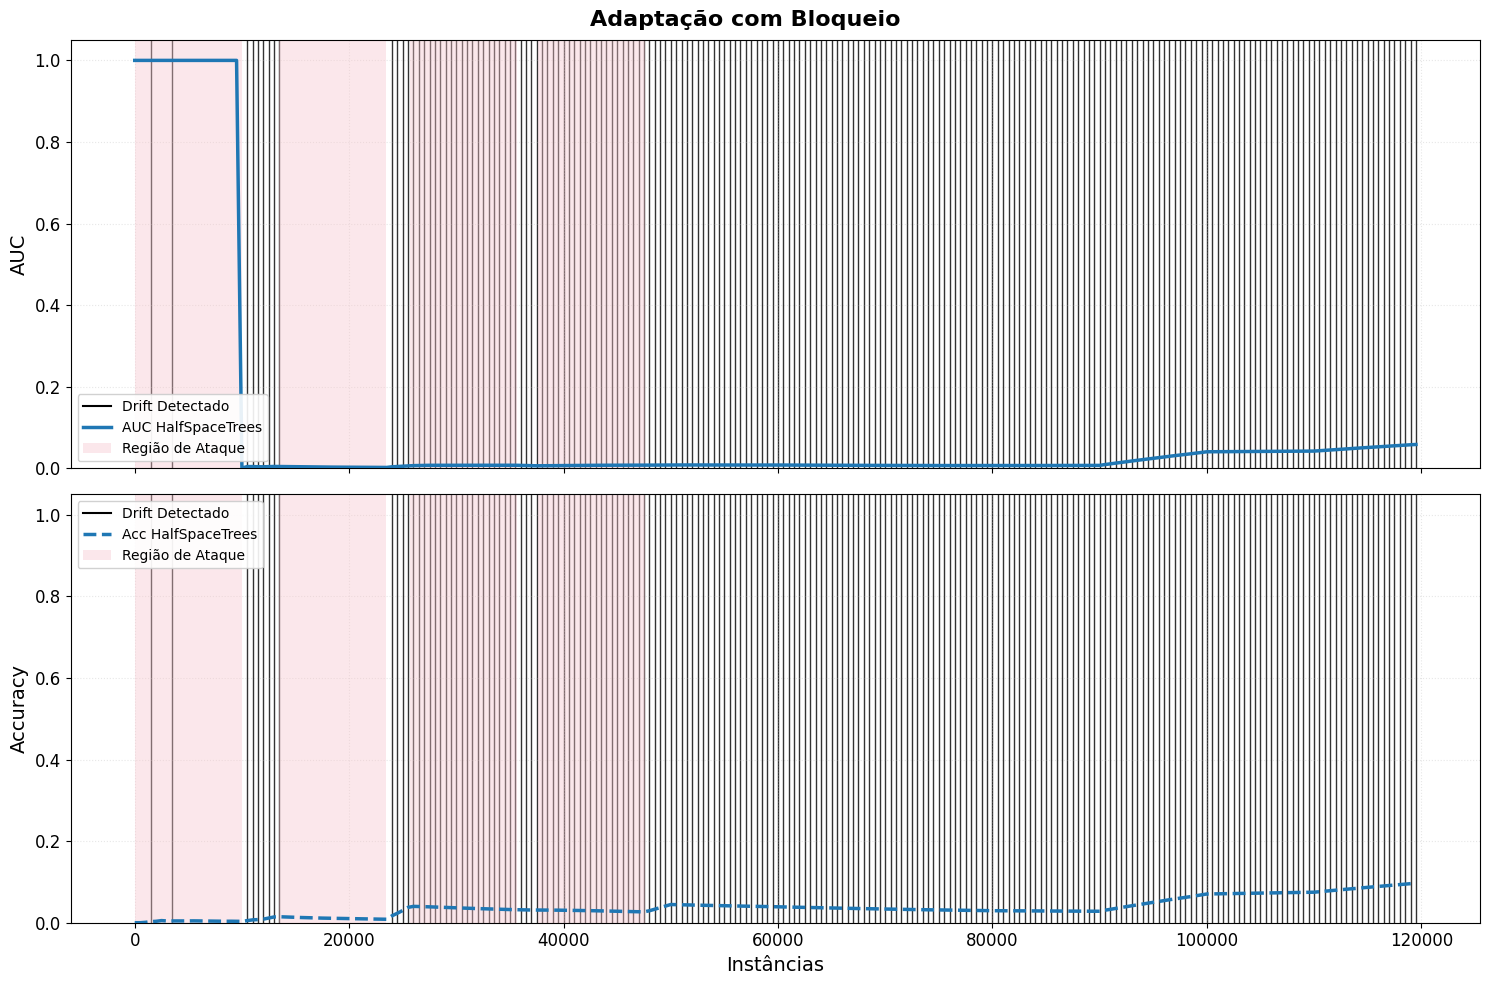

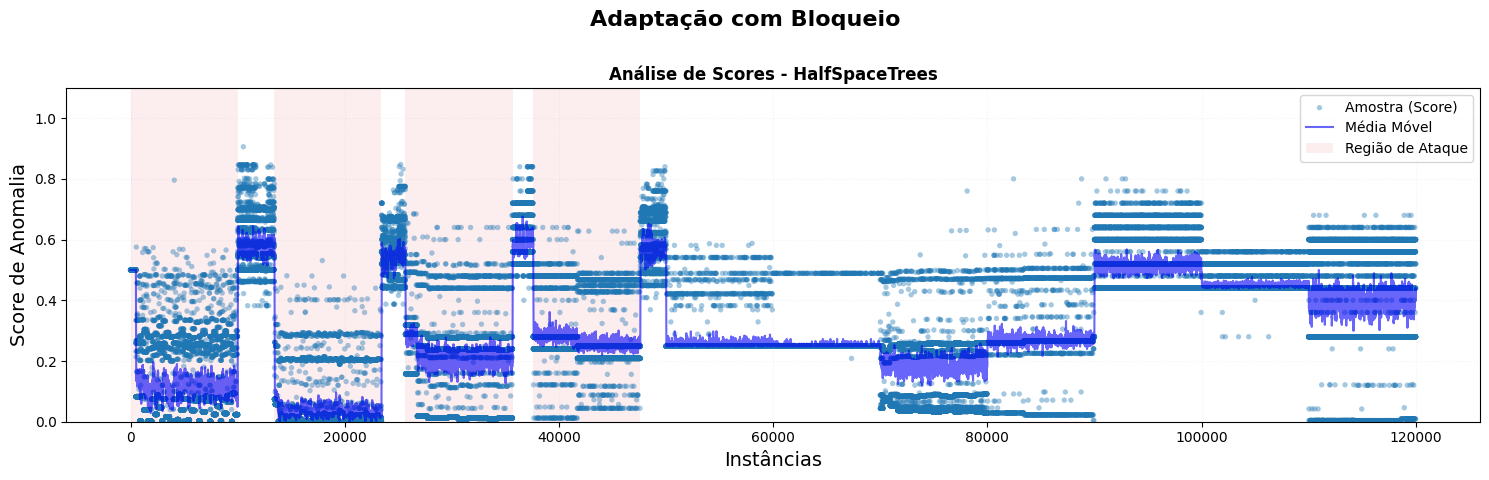

In [7]:
from py.AnomalyDetectionPipeline import AnomalyExperimentRunner
from py.AnomalyDetectionModels import get_anomaly_models

# Instanciar a classe
runner = AnomalyExperimentRunner()

# Configurar seus algoritmos 
algoritmos = get_anomaly_models(
    stream.get_schema(), 
    selected_models=['HST']
)

# Pipeline Adaptativo 
runner.ExecuteExperiments(
    stream=stream,
    pipeline_name='adaptive', # 'adaptive', 'standard', ou 'memory'
    algorithms=algoritmos,
    warmup_windows=1,
    window_size=500,
    anomaly_threshold=0.2,
    beta=0.3,
    title="Adaptação com Bloqueio",
    logging=False
)

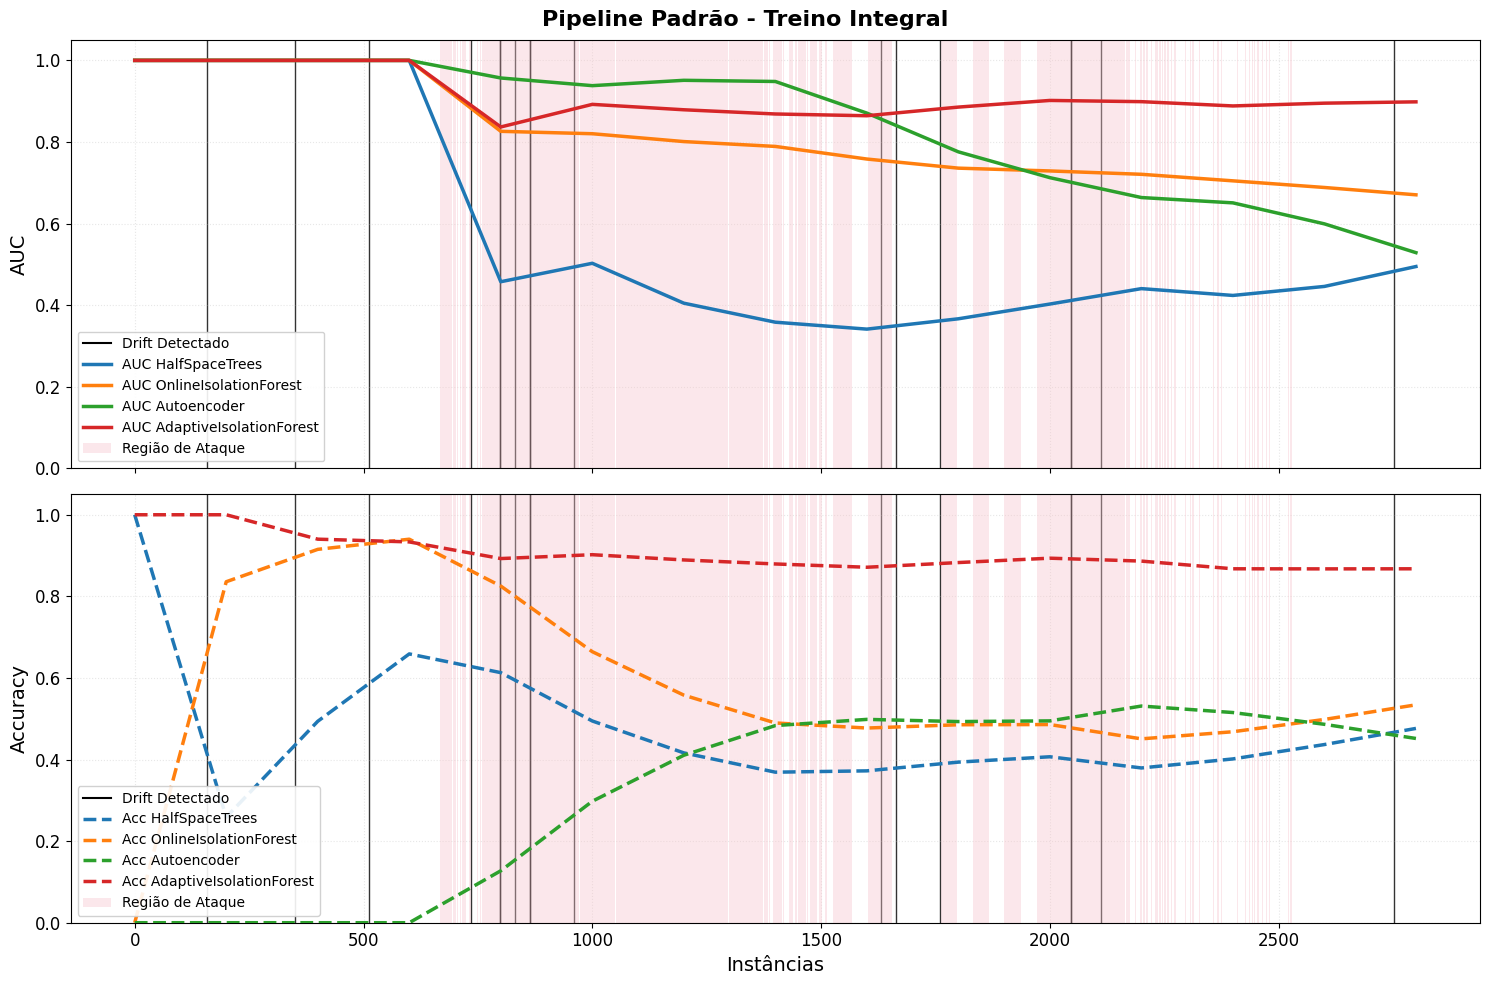

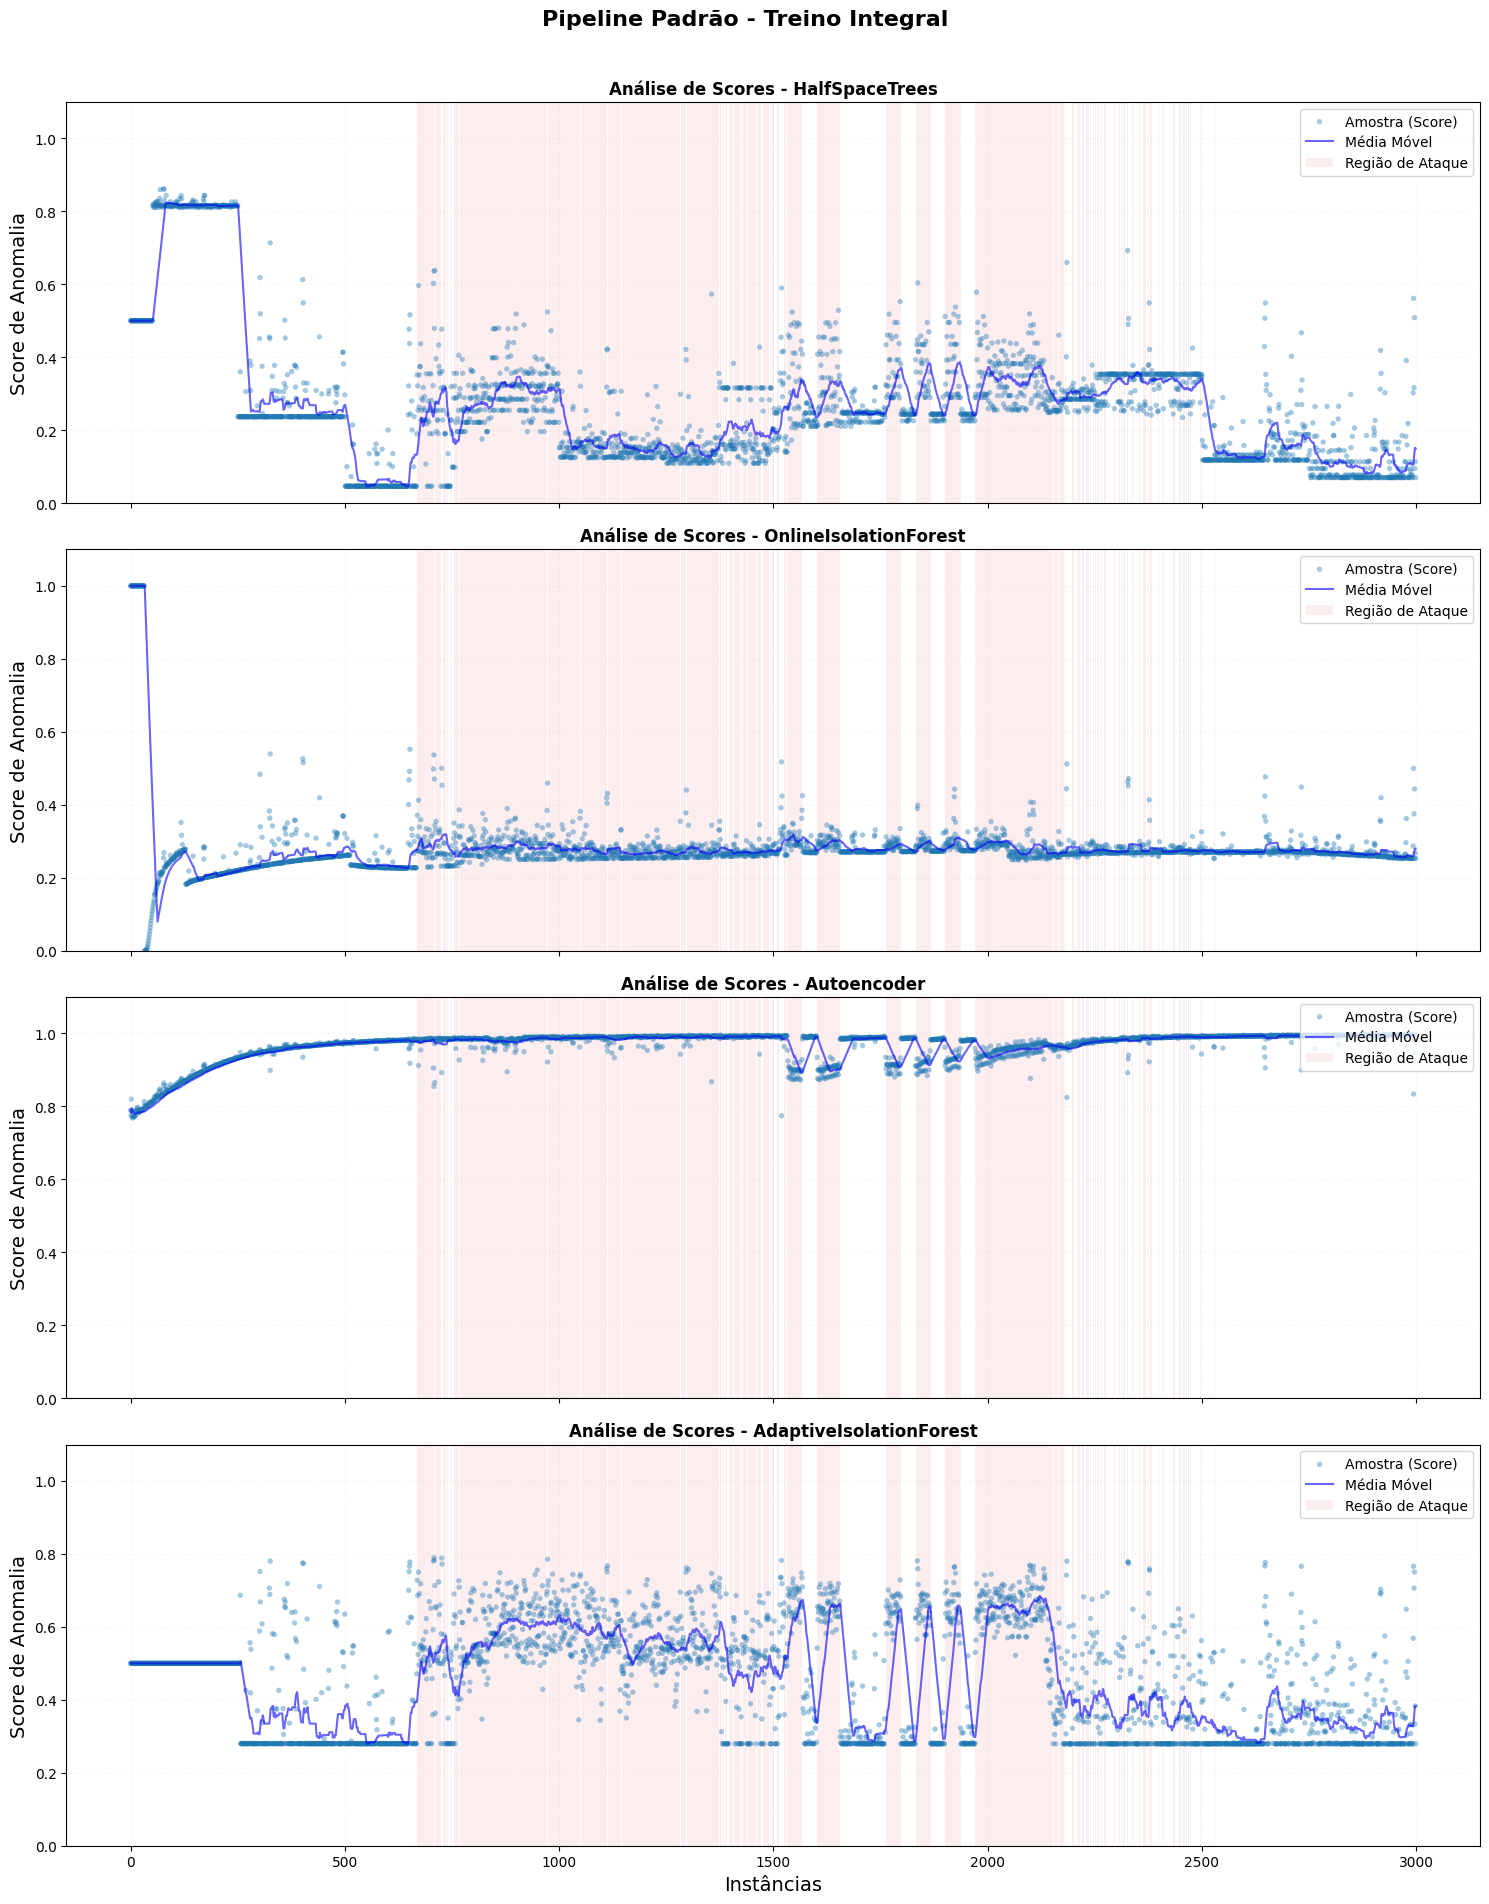

In [ ]:
from py.AnomalyDetectionPipeline import AnomalyExperimentRunner
from py.AnomalyDetectionModels import get_anomaly_models

# Instanciar a classe
runner = AnomalyExperimentRunner()

# Configurar seus algoritmos 
algoritmos = get_anomaly_models(
    stream, 
    selected_models=['AE', 'HST', 'OIF', 'AIF']
)

# Pipeline Padrão 
runner.ExecuteExperiments(
    stream=stream, 
    pipeline_name='standard', 
    algorithms=algoritmos,
    window_size=200, 
    title="Pipeline Padrão - Treino Integral"
)

[HalfSpaceTrees] Instância: 0
  > Novas amostras aceitas: 1 | Histórico: 1
  > Ocupação da Fila: 1/500
[HalfSpaceTrees] Instância: 200
  > Novas amostras aceitas: 201 | Histórico: 201
  > Ocupação da Fila: 201/500
[HalfSpaceTrees] Instância: 400
  > Novas amostras aceitas: 401 | Histórico: 401
  > Ocupação da Fila: 401/500
[HalfSpaceTrees] Instância: 600
  > Novas amostras aceitas: 601 | Histórico: 601
  > Ocupação da Fila: 500/500
  > AVISO: A memória (K=500) foi totalmente renovada 1.2x nesta janela.
[HalfSpaceTrees] Instância: 800
  > Novas amostras aceitas: 790 | Histórico: 790
  > Ocupação da Fila: 500/500
  > AVISO: A memória (K=500) foi totalmente renovada 1.6x nesta janela.
[HalfSpaceTrees] Instância: 1000
  > Novas amostras aceitas: 977 | Histórico: 977
  > Ocupação da Fila: 500/500
  > AVISO: A memória (K=500) foi totalmente renovada 2.0x nesta janela.
[HalfSpaceTrees] Instância: 1200
  > Novas amostras aceitas: 1174 | Histórico: 1174
  > Ocupação da Fila: 500/500
  > AVISO: 

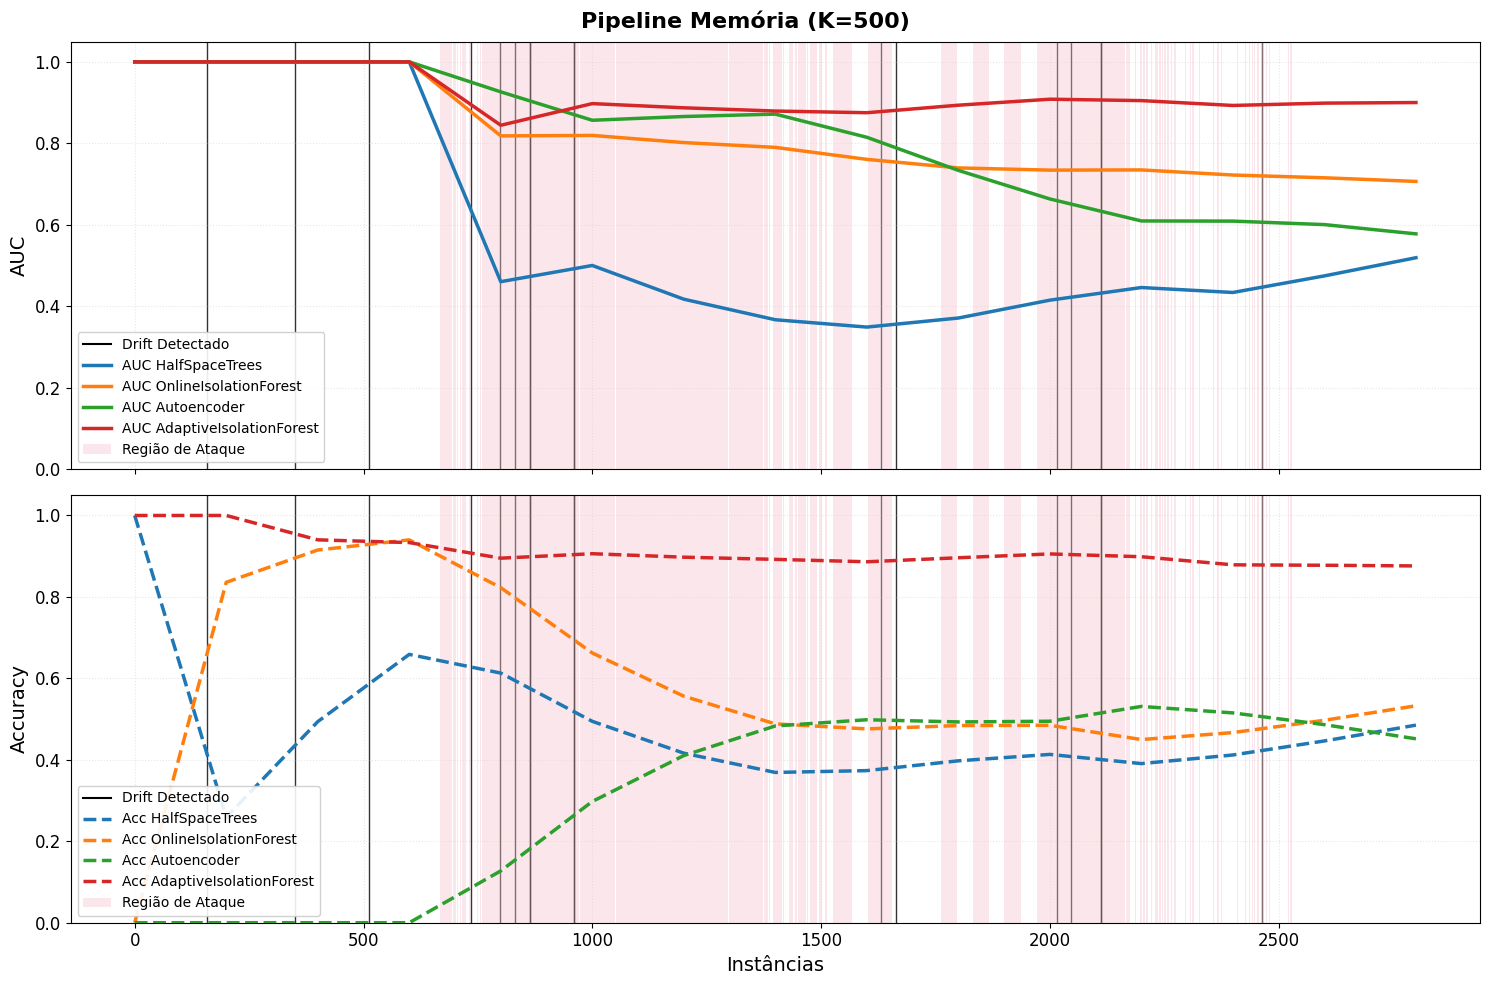

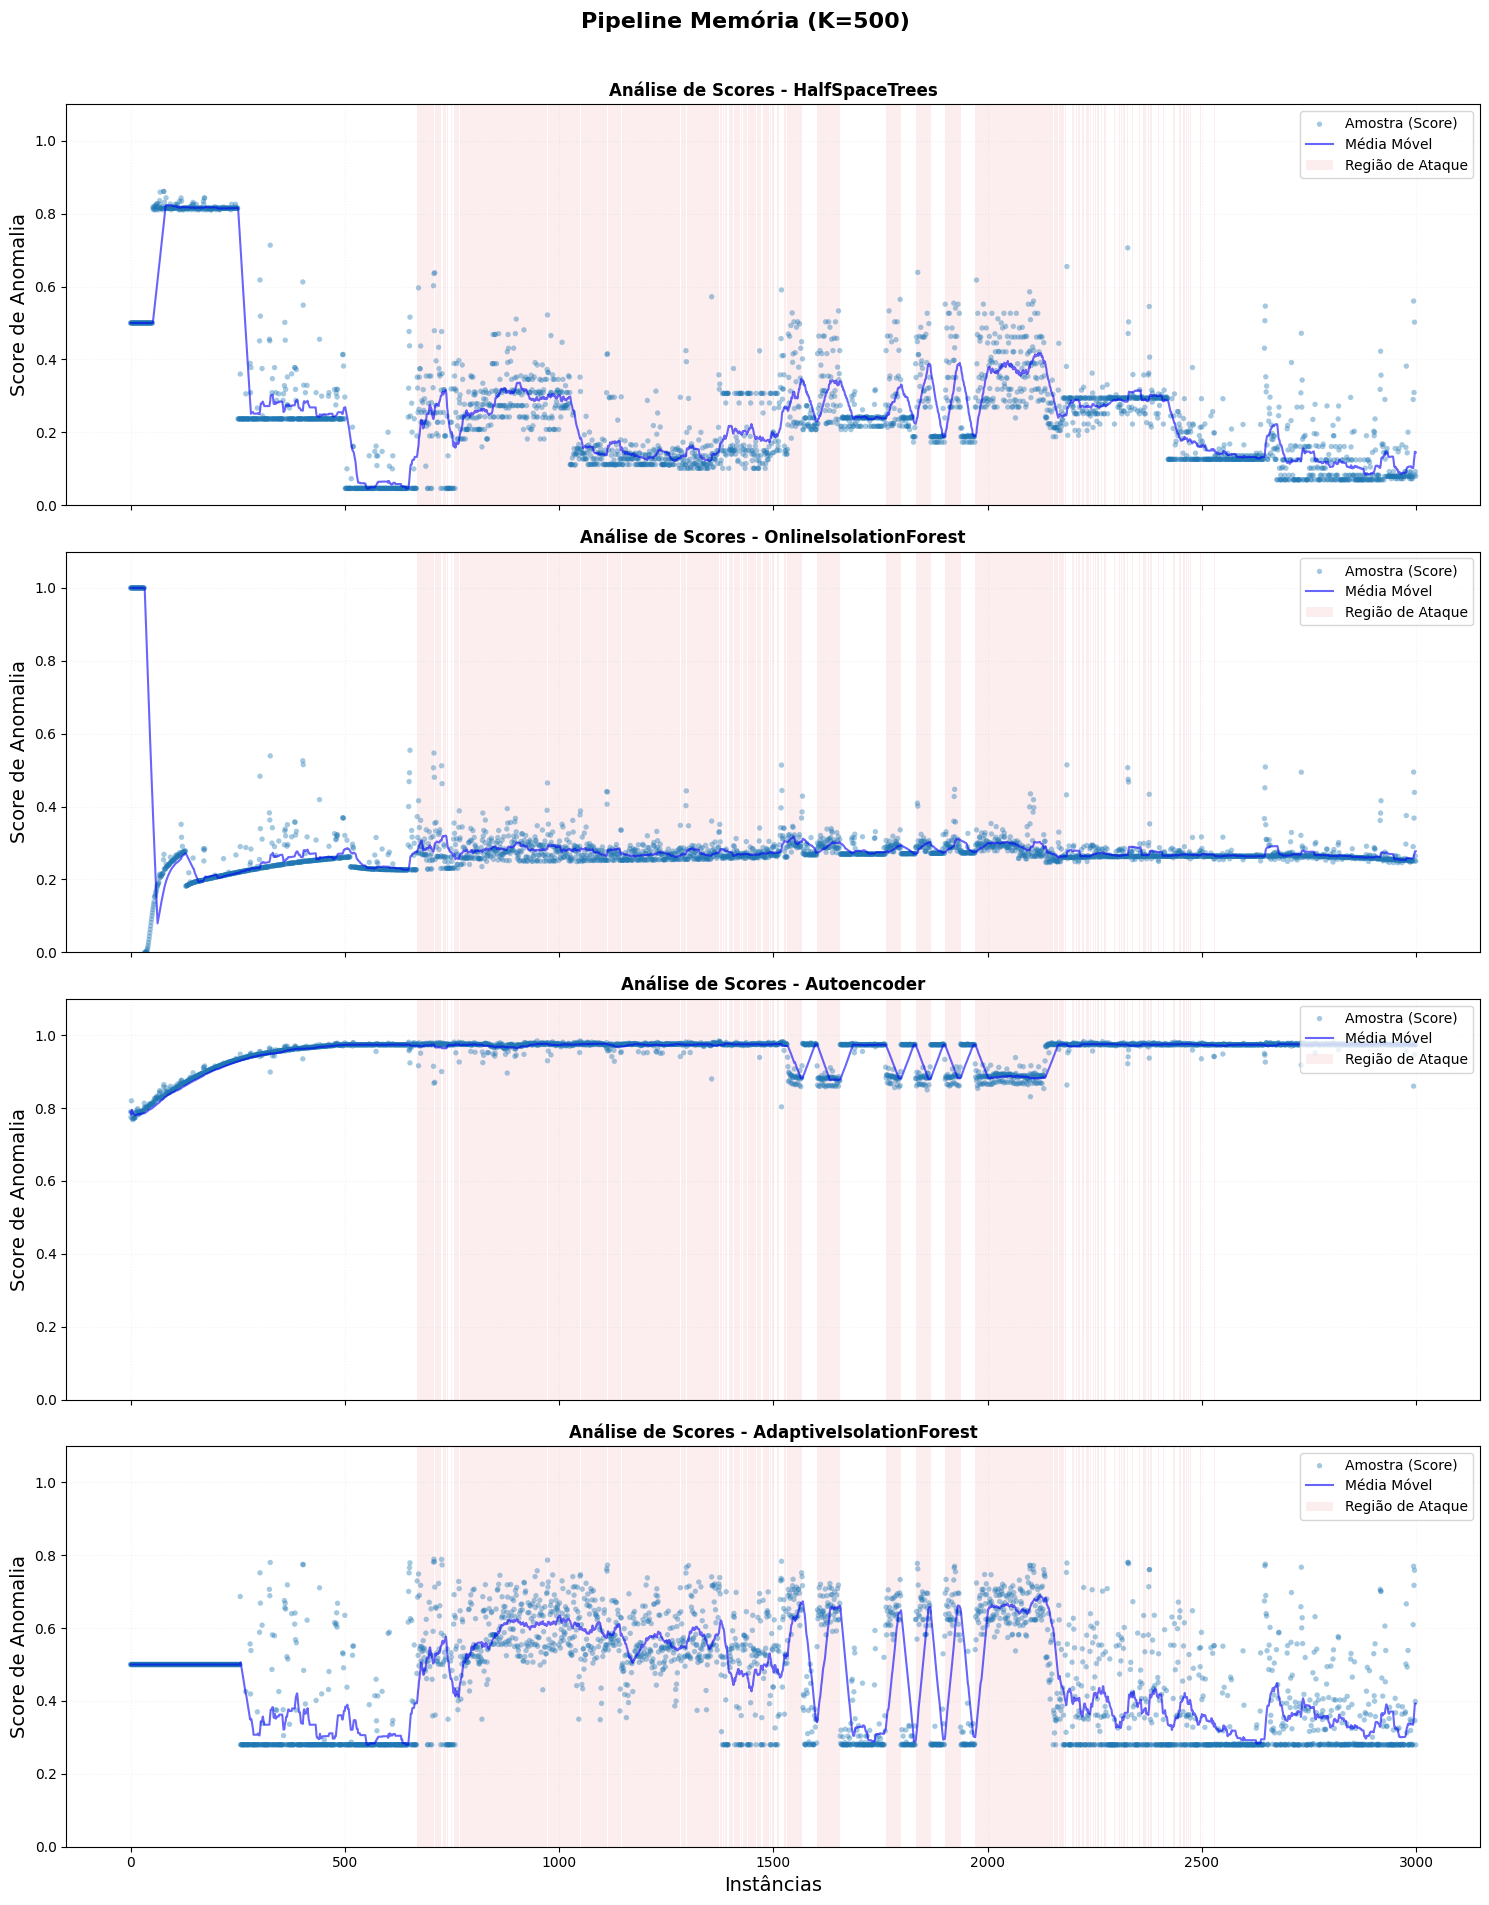

In [ ]:
from py.AnomalyDetectionPipeline import AnomalyExperimentRunner
from py.AnomalyDetectionModels import get_anomaly_models

# Instanciar a classe
runner = AnomalyExperimentRunner()

# Configurar seus algoritmos 
algoritmos = get_anomaly_models(
    stream.get_schema(), 
    selected_models=['AE', 'HST', 'OIF', 'AIF']
)

# Pipeline Memória
runner.ExecuteExperiments(
    stream=stream, 
    pipeline_name='memory', 
    algorithms=algoritmos, 
    K_MEM=500,
    window_size=200, 
    title="Pipeline Memória (K=500)", 
    anomaly_threshold=0.4, 
    logging=False
)

# CapyMOA

In [9]:
# Importa a classe do arquivo local (certifique-se de que online_isolation_forest.py está na mesma pasta)
from py.capyMOA._online_isolation_forest import OnlineIsolationForest
import numpy as np
import matplotlib.pyplot as plt 
from py.DataStreamProcessor import DataStreamProcessor
import pandas as pd

INICIO = 10000
FIM = 20000
TOTAL_AMOSTRAS = FIM - INICIO
MAX_INSTANCES = TOTAL_AMOSTRAS

df = pd.read_csv(
    'datasets/CICDDoS2019/data/01-12/Classification/DNS_DNS_DNS.csv', 
    skiprows=range(1, INICIO), 
    nrows=TOTAL_AMOSTRAS
)

processor = DataStreamProcessor(logging=True)

stream, targets, features = processor.create_stream(
    df=df, 
    target_label_col='Label', 
    binary_label=True, 
    normalize_method="MinMaxScaler", 
    threshold_var=0.001,
    threshold_corr=None,
    top_n_features=10,
    return_stream=True,
    extra_ignore_cols=['Source IP', 'Source Port','Destination IP','Destination Port','Protocol'],
    imputation_method='mediana'
)

Limpeza: Removendo espaços, identificadores (Flow ID, Timestamp, Unnamed: 0) e colunas vazias...
Pré-processamento: Convertendo infinitos...
Tratamento de Nulos: Preenchendo com a MEDIANA das colunas...
Normalização: MinMaxScaler
Target: Processando coluna 'Label' como Binário (0=Normal, 1=Attack)...
Seleção de Features: Iniciando pipeline de redução de dimensionalidade...

--- Iniciando Processo de Seleção de Features (Total: 78) ---
Variância: 23 features removidas. Restantes: 55
Remover Correlação: Pular.
Random Forest: Top 10 selecionadas.
Features Finais (10) - ['Fwd Packet Length Min', 'Min Packet Length', 'Avg Fwd Segment Size', 'Average Packet Size', 'Packet Length Mean', 'act_data_pkt_fwd', 'Fwd Packet Length Mean', 'Subflow Fwd Bytes', 'Fwd Packet Length Max', 'Bwd IAT Max']
--- Fim do Processo de Seleção de Features ---

Finalização: Criando objeto NumpyStream para o CapyMOA.



01:13:09 - INFO - Inicializando oIFOR: 32 árvores, janela de 2048, subsample=1.0


Iniciando o processamento de 10000 instâncias...
Instante 005000 processado | Último Score: 0.2558
Processamento da stream concluído com sucesso!


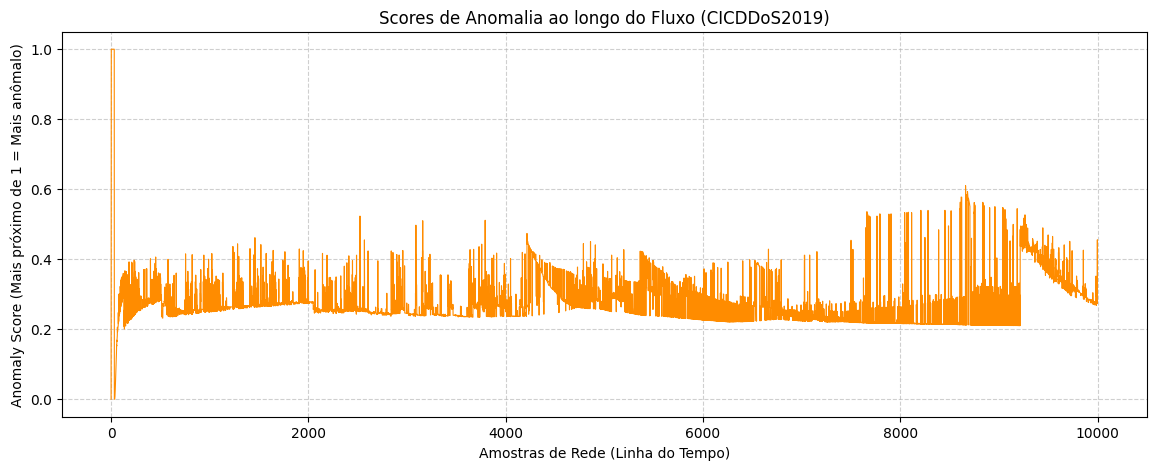

In [10]:
# Inicializando o modelo Online Isolation Forest
# Parâmetros baseados na recomendação do artigo para streams complexas
modelo_oif = OnlineIsolationForest(
    num_trees=32,
    window_size=2048, # Define a janela deslizante de pacotes mantidos em memória
    n_jobs=-1         # Usa todos os núcleos da sua máquina para paralelismo
)

# Lista para armazenar os scores gerados e facilitar a visualização no Jupyter
scores_anomalia = []


print(f"Iniciando o processamento de {len(stream)} instâncias...")

# 2. Iterando sobre o fluxo (simulando a chegada contínua de pacotes de rede)
for t, instancia in enumerate(stream):
    
    # Extrai o array NumPy de features de dentro do objeto LabeledInstance
    vetor_x = instancia.x
    
    # A) AVALIAÇÃO (Score): Testa a amostra nova antes de aprendê-la
    if t > 0: 
        score = modelo_oif.score_instance(vetor_x)
        scores_anomalia.append(score)
        
        # Print a cada 5000 pacotes para acompanhar o progresso sem travar o Jupyter
        if t % 5000 == 0:
            print(f"Instante {t:06d} processado | Último Score: {score:.4f}")
    else:
        # Para t=0, a árvore está vazia
        scores_anomalia.append(0.0) 
        
    # B) TREINAMENTO (Train): Ensina a nova amostra ao modelo e descarta a mais velha
    modelo_oif.train(vetor_x)
print("Processamento da stream concluído com sucesso!")
plt.figure(figsize=(14, 5))
plt.plot(scores_anomalia, color='darkorange', linewidth=0.8)
plt.title('Scores de Anomalia ao longo do Fluxo (CICDDoS2019)')
plt.xlabel('Amostras de Rede (Linha do Tempo)')
plt.ylabel('Anomaly Score (Mais próximo de 1 = Mais anômalo)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()